# Party Political Sentiment Analysis 

# Introduction
The aim of this project was to use a record of speeches in the UK Parliament to train an algorithm which could identify the political party a speaker belonged to.  
My initial attempts (not shown) to build a RNN out of LSTM and Dense layers were able to achieve results better than chance, but not high enough to satisfy me. This was despite extensive hyperparameter tuning using the `optuna` package.  
<br>
I was more successful using the `hugging_face` library of transformers. I fine-tuned the [`politicalbiasBERT`](https://huggingface.co/bucketresearch/politicalBiasBERT) model on my dataset. The `politicalbiasBERT` model is itself a fine-tuned version of BERT, trained on a dataset of politically biased news articles to identify `LEFT` `RIGHT` and `CENTRE` [(*Baly et al 2020*)](https://doi.org/10.48550/arXiv.2010.05338).  
<br>
Whilst I was initially sceptical that the learned sentiment patterns in American news reports would be transferable to the party affiliations of British politicians, I was surprised at the success of this approach. With the model achieving >80% accuracy on unseen test data using the below methodology.

In [ ]:
%%capture
!pip install transformers[torch]
! pip install transformers datasets
!pip install torchinfo
! pip install evaluate

import numpy as np
import pandas as pd

import transformers
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback
import datasets
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel, Features, load_metric

import torch
import torch.nn as nn
from torchinfo import summary

import evaluate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Data

I am using the `hansard` dataset, which is the official record of everything said in the British Parliament. The official record began in 1909, but an online dataset covering May 1979-July 2020 is available online [**here**](https://evanodell.com/projects/datasets/hansard-data/) and, conveniently, on the `hugging_face` platform.  
<br>
Labour and Conservative together make up >90% of all the speeches in this dataset, so I decided to remove all others. Due to the peculiarities of the British parliamentary system there are also some parties which are *kind of* part of Labour/Conservative but are listed as different in Hansard, so I rename those.  
<br>
I also remove all procedural speeches, which are the same regardless of party and would confuse the model, and limit the dataset to everything since the year 2000. This final step is due to my limited computational power, if you have less of a computational limit I'd be interested to see if the model performs better or worse if this constraint is relaxed!  
<br>
Once all these steps are complete we have about 1 million speeches to work with.  

In [ ]:
# this can take a while
hansard_raw = load_dataset('biglam/hansard_speech',
                           split='train[:100%]'
                           )

In [ ]:
%%capture
def limit_years(row, cutoff='1999'): # limit to 2000 onwards
    year = row['year']
    return int(year) > int(cutoff)

def remove_nonspeeches(dataset): # remove procedural speeches
  return dataset['speech_class'].lower() == 'speech'

def rename_parties(row): # rename parties
    party_mapping = {
        'Independent Labour': 'Labour',
        'Labour (Co-op)': 'Labour',
        'Independent Conservative': 'Conservative',
    }
    row['party'] = party_mapping.get(row['party'], row['party'])
    return row

def remove_other_parties(dataset): # remove parties other than Lab/Con
  targets = {'Labour', 'Conservative'}
  if dataset['party'] in targets:
    return True
  else:
    return False


def check(dataset, party_column='party'): # a way to check the dataset is as expected
  party_counts = pd.Series(dataset[party_column]).value_counts()
  proportions = party_counts / party_counts.sum()

  print(dataset)
  print(party_counts)
  print(proportions.round(2))

def data_cleaning(dataset): # applies the above functions successively
  keep = {'id', 'speech', 'party'}
  columns_to_remove = [c for c in dataset.features if c not in keep]

  updated_dataset = dataset.filter(remove_nonspeeches)
  updated_dataset = updated_dataset.filter(limit_years)
  updated_dataset = updated_dataset.map(rename_parties, remove_columns=columns_to_remove)
  updated_dataset = updated_dataset.filter(remove_other_parties)

  return updated_dataset

hansard = data_cleaning(hansard_raw)

In [ ]:
check(hansard)

Dataset({
    features: ['id', 'speech', 'party'],
    num_rows: 1055933
})
Conservative    566334
Labour          489599
Name: count, dtype: int64
Conservative    0.54
Labour          0.46
Name: count, dtype: float64


# Pre-processing
To pre-process the data we tokenize using `bert-base-cased` and then encode the party labels as numerical `class_labels`.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
  return tokenizer(examples['speech'], padding='max_length', truncation=True)

def data_processing(dataset):
  dataset = dataset.rename_column('party', 'label').class_encode_column('label')
  dataset = dataset.map(tokenize_function, batched = True)

  return dataset

hansard = data_processing(hansard)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Flattening the indices:   0%|          | 0/1055933 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1055933 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055933 [00:00<?, ? examples/s]

# Test - Train - Validation Split
I use the `sklearn` `train_test_split()` to generate my test, train, and validation data in a stratified manner, so that I can preserve the slight imbalance in my data.   
<br>
The function `train_val_test_split()` leverages `sklearn` to split the dataset into three whilst retaining the proportions of Lab/Con.  
I split 80:20 `train`:`validation`, and then split the `train` again 80:20 `train`:`test`.  
<br>
These three datasets are combined into a single `combined_hansard` dataset which can be saved at this stage.  


In [ ]:
def indices_train_test_split(dataset, test_size=0.2): # using indices is much quicker
  y = list(dataset['label'])
  indices = np.arange(len(dataset))

  train_indices, test_indices, _, _ = train_test_split(indices, y, test_size = test_size, stratify=y, random_state=42)
  train_dataset = dataset.select(train_indices)
  test_dataset = dataset.select(test_indices)

  return train_dataset, test_dataset

def train_val_test_split(dataset):
  train_test, validation = indices_train_test_split(dataset)
  train, test = indices_train_test_split(train_test)

  return train, validation, test

hansard_train, hansard_validation, hansard_test = train_val_test_split(hansard)

combined_hansard = DatasetDict({
    'train' : hansard_train,
    'validation' : hansard_validation,
    'test' : hansard_test
})

print(combined_hansard)

DatasetDict({
    train: Dataset({
        features: ['id', 'speech', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 675796
    })
    validation: Dataset({
        features: ['id', 'speech', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 211187
    })
    test: Dataset({
        features: ['id', 'speech', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 168950
    })
})


# Model
As I described above, I am using the `politicalbiasBERT` model, a fine-tuned version of BERT, trained on a dataset of politically biased news articles.  
<br>
I replace the final classifier weights and bias with blank layers that will classify into two outputs. I then initialize the `classifier.weight` and `classifier.bias` layers with xavier random weights and zeros respectively.

In [ ]:
%%capture
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT",
                                                           num_labels=2,
                                                           ignore_mismatched_sizes=True)

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [ ]:
num_classes = 2

# replace final layer weights and biases
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# initialize the new layers
nn.init.xavier_uniform_(model.classifier.weight) #xavier random weights
nn.init.zeros_(model.classifier.bias) #bias initialised with zero

Parameter containing:
tensor([0., 0.], requires_grad=True)

# To freeze or not to freeze?
I found slightly better results when I unfroze the entire model, rather than freezing all but the final encoder layer, which the hashed code below does. Feel free to experiment with this however, as I may not have the optimal methology.  
<br>
I think unfreezing is most effective because, whilst similar, the task `politicalbiasBERT` has been trained to do (identify bias in American media) is substantially different to my application here. Therefore the weights may be relatively far from optimal.

In [ ]:
#### FREEZING ALL BUT TARGET LAYERS ####

# target_layers = []

# for name, param in model.named_parameters(): # freeze all
#   param.required_grad = False

# for name, param in model.named_parameters():
#     if 'layer.11' in name:
#         target_layers.append(name)

# target_layers.extend(['bert.pooler.dense.weight',
#                  'bert.pooler.dense.bias',
#                  'classifier.weight',
#                  'classifier.bias'])

# for name, param in model.named_parameters(): # unfreeze target layers
#   if name in target_layers:
#     param.required_grad = True
#     print(f'{name} unfrozen')

In [ ]:
for name, param in model.named_parameters(): # unfreeze all
  param.required_grad = True

### Training
Now time for the exciting bit!  
<br>
I found a low `learning_rate` most effective. This is to avoid skipping over the optima (a problem I frequently encountered).  I also found that the transformer model learns quite quickly, with validation loss bottoming out after around 3 epochs. After this I found it very quickly overfits, so I set the `early_stopping` patience to `1`.  
<br>`hugging_face` transformers will automatically choose the correct loss function for the optimizer, in this case it is `CrossEntropyLoss()`.  


In [ ]:
%%capture
training_args = TrainingArguments(output_dir='training',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  learning_rate = 5e-6,
                                  num_train_epochs = 10,
                                  per_device_train_batch_size=16,
                                  load_best_model_at_end = True)

metric = evaluate.load('accuracy')

def compute_metrics_acc(eval_pred): # computes accuracy
    logits, labels = eval_pred #unpack logits and labels
    predictions = np.argmax(logits, axis=-1) # compute predictions

    return metric.compute(predictions=predictions, references=labels) # compute accuracy

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = combined_hansard['train'],
    eval_dataset = combined_hansard['validation'],
    compute_metrics = compute_metrics_acc,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

trainer.train()

trainer.save_model('/model')

# Test data
With test data held-out and not used in the training process, the mode achieved an `test_accuracy` of 81% and `test_loss` of 0.4.  
The results are also plotted below in a `confusion_matrix`.

In [ ]:
test_data = combined_hansard['test']
prediction_output = trainer.predict(test_data)
predictions = prediction_output[0]
true_classes = prediction_output[1]

# convert predictions to tensor and predict class
probabilities = torch.softmax(torch.tensor(predictions), dim=1).numpy()
predicted_classes = probabilities.argmax(axis=1)

test_loss = prediction_output.metrics['test_loss']
test_accuracy = prediction_output.metrics['test_accuracy']

print(f'On unseen test data: \n Test loss = {test_loss} \n Test accuracy = {test_accuracy}')

On unseen test data: 
 Test loss = 0.3961300551891327 
 Test accuracy = 0.8089079609351879


<Axes: >

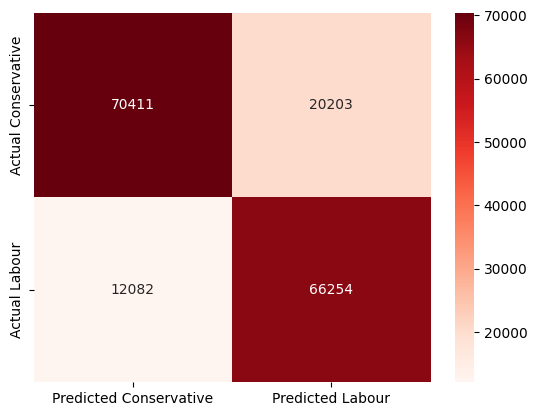

In [ ]:
def plot(true_classes, predicted_classes):
  labels = combined_hansard['test'].features['label'].names
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  matrix = confusion_matrix(true_classes, predicted_classes)

  table = pd.DataFrame(matrix, columns=columns, index=index)
  plot = sns.heatmap(table, annot=True,
                     fmt = 'd',
                     cmap = 'Reds'
                     )

  return plot

plot(true_classes, predicted_classes)

# Conclusions  
I was able to achieve >80% accuracy and loss of about 0.4 on held-out test data. From the confusion plot it looks like the model was slightly better at categorising Conservative speeches than Labour, this may be due to their overrepresentation in the dataset, allowing more opportunity for the model to learn.  
<br>
Unfortunately I was only able to train for 2 epochs before I ran out of compute resources. However, when I tested this with smaller datasets the model tended to start overfitting on the 3rd or 4th epoch. So there was probably only marginal improvements left to be found.  
<br>
This was a long project, and my first attempt at ML. There was a steep learning curve, but it was incredibly valuable journey which taught me a lot about understanding data analysis, preprocessing, and fundamental ML science concepts.  
<br>
This project could be taken in further directions, for example the model could be trained on the entire dataset from 1979-2020 where it might achieve higher accuracy. Additionally this model could be tested on data from different time periods to see if the party political language used by politicians in the 2000s is useful to categorise historical speeches, maybe it would be less effective in certain time periods when Labour / Conservative are agreeing more.  
<br>
I think I'm going to move onto a different project for now though.